In [1]:
%load_ext autoreload
%autoreload 2

In [44]:
from functions import *
import tensorflow as tf
from livelossplot import PlotLossesKeras
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [45]:
stream = "gd1_tail"

In [46]:
df = load_file(stream = stream, percent_bkg = 15)

Before reduction, stream stars make up 0.039% of the dataset.
After reduction, stream stars make up 0.256% of the dataset.


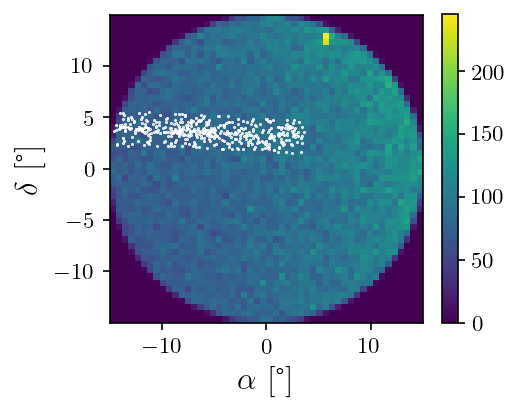

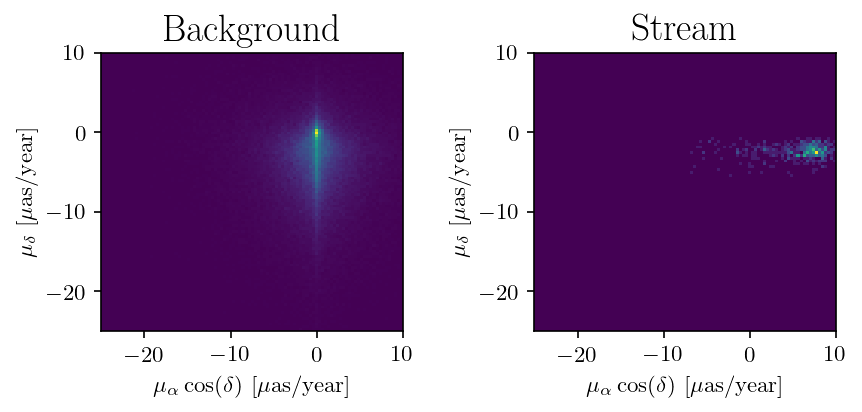

In [47]:
visualize_stream(df)

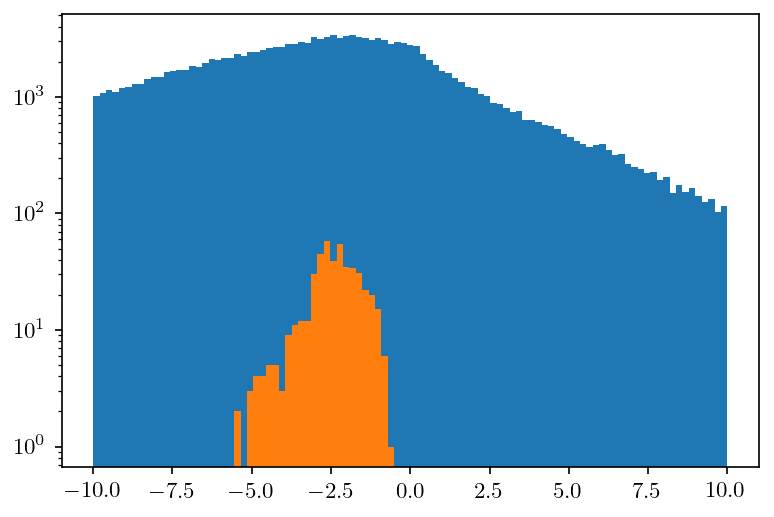

In [48]:
bins=np.linspace(-10,10,100)
plt.hist(df.μ_δ, bins=bins);
plt.hist(df[df.stream == True].μ_δ, bins=bins);
plt.yscale('log')

/home/mpettee/GaiaCWoLa/functions.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plt.hist(df_slice[df_slice.label == 1].μ_δ,bins=bins,color="dodgerblue",label="Signal Region")


Total counts: SR = 51,649, SB = 47,336
Signal region has 395 stream and 51,254 bkg events.
Sideband region has 66 stream and 47,270 bkg events.


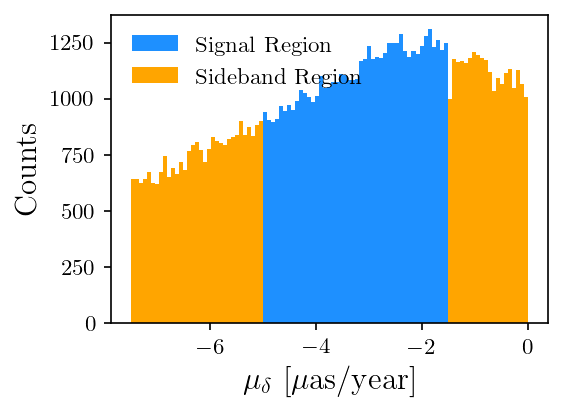

In [49]:
df_slice = signal_sideband(df, stream = stream)

In [54]:
### Prepare datasets for training
if 'color' in df.keys(): 
    training_vars = ['μ_α','δ','α','color','mag']
elif 'b-r' in df.keys():
    training_vars = ['μ_α','δ','α','g','b-r']
train, validate, test = np.split(df_slice.sample(frac=1), [int(.7*len(df_slice)), int(.85*len(df_slice))]) # 70/15/15 train/validate/test split

x_train, x_val, x_test = [train[training_vars], validate[training_vars], test[training_vars]]
y_train, y_val, y_test = [train.label, validate.label, test.label]

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

print("Training on {:,} events.".format(len(train)))

Training on 69,289 events.


In [55]:
### Define model architecture 
layer_size = 32
dropout = 0.1
reg = regularizers.l2(1e-4)

model = Sequential()
model.add(Dense(layer_size, input_dim=len(training_vars), activation='relu',
               activity_regularizer=reg
               )) 
if dropout != 0: 
    model.add(Dropout(dropout))
model.add(Dense(layer_size, activation='relu',
               activity_regularizer=reg
               ))
if dropout != 0: 
    model.add(Dropout(dropout))
model.add(Dense(layer_size, activation='relu',
               activity_regularizer=reg
               ))
if dropout != 0: 
    model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

# stops if val_loss doesn't improve for [patience] straight epochs
early_stopping = callbacks.EarlyStopping(monitor='val_loss', 
                                         patience=20, 
                                         verbose=1) 

# saves weights from the epoch with lowest val_loss 
checkpoint = callbacks.ModelCheckpoint("weights.h5", 
                                       monitor='val_loss', 
                                       mode='auto', 
                                       verbose=1, 
                                       save_best_only=True, 
                                       save_weights_only=True)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 32)                192       
_________________________________________________________________
dropout_42 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_43 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_44 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 1)               

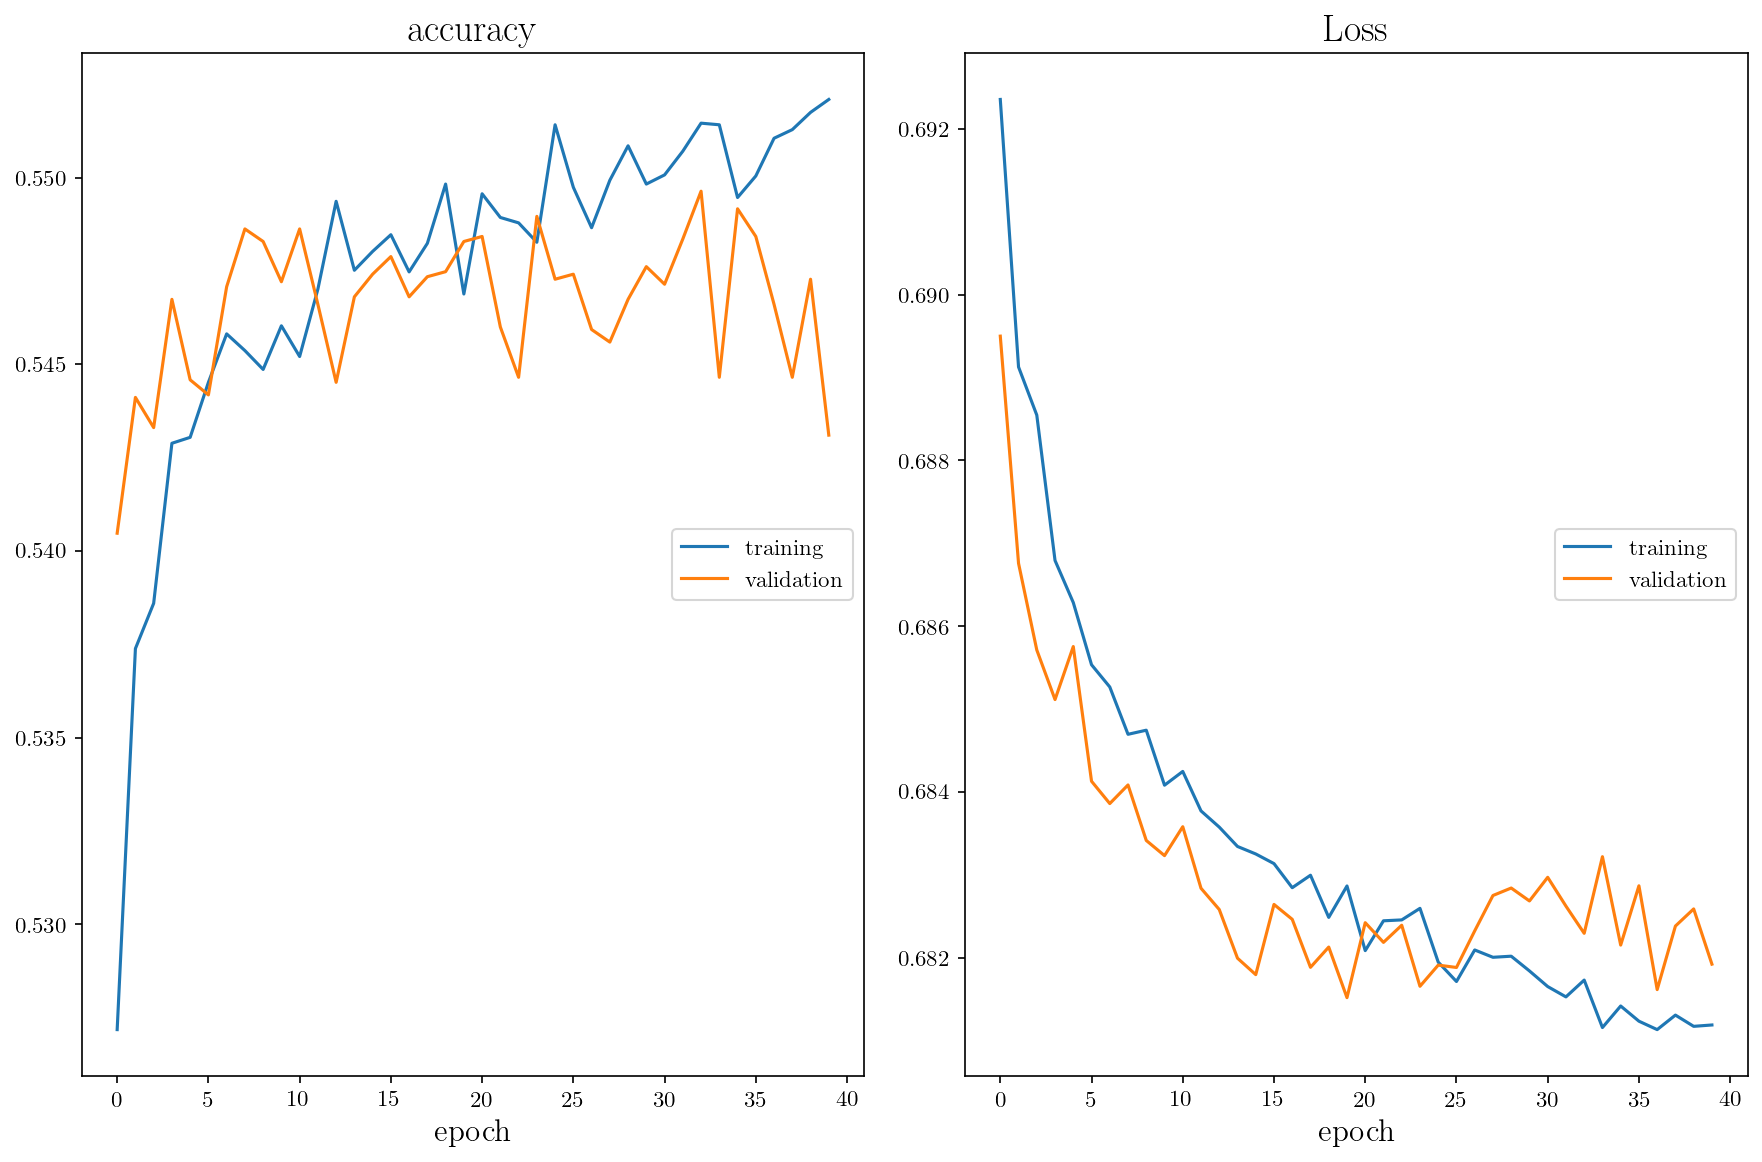

accuracy
	training         	 (min:    0.527, max:    0.552, cur:    0.552)
	validation       	 (min:    0.540, max:    0.550, cur:    0.543)
Loss
	training         	 (min:    0.681, max:    0.692, cur:    0.681)
	validation       	 (min:    0.682, max:    0.690, cur:    0.682)

Epoch 00040: val_loss did not improve from 0.68152
Epoch 00040: early stopping


In [56]:
### Train!
history = model.fit(x_train, y_train, 
                    epochs=100, 
                    batch_size=64,
                    validation_data=(x_val,y_val),
                    callbacks = [PlotLossesKeras(),checkpoint,early_stopping],
                    verbose = 2,
                   )

AUC: 0.564
Maximum purity of 2.6% at 12.13%
No stream matches identified in top star selection.
Cut at 0.001%...
Purity: 0.0%
No stream matches identified in top star selection.
Cut at 0.01%...
Purity: 0.0%
No stream matches identified in top star selection.
Cut at 0.1%...
Purity: 0.0%
No stream matches identified in top star selection.
Cut at 1%...
Purity: 0.0%
Cut at 5%...
Purity: 2.2%
Cut at 10%...
Purity: 2.5%
Cut at 20%...
Purity: 2.0%


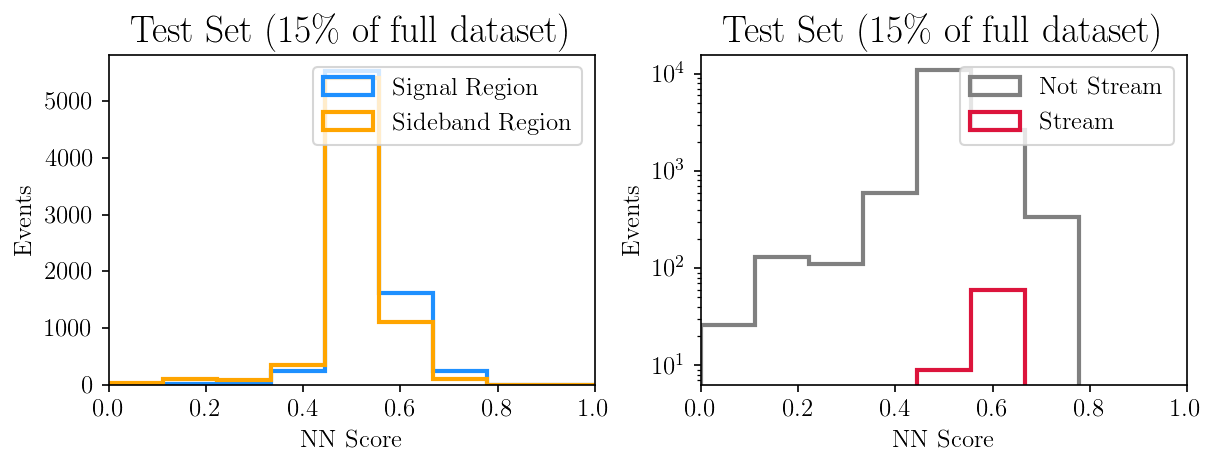

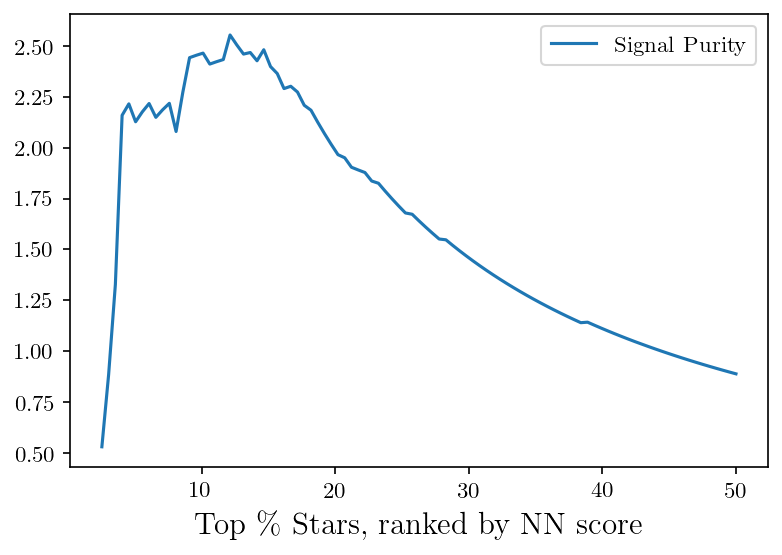

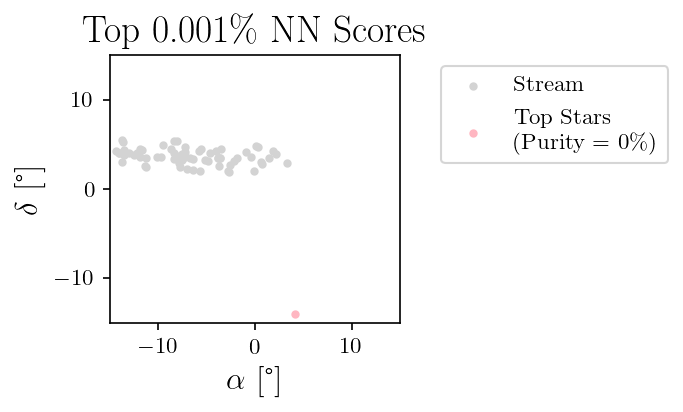

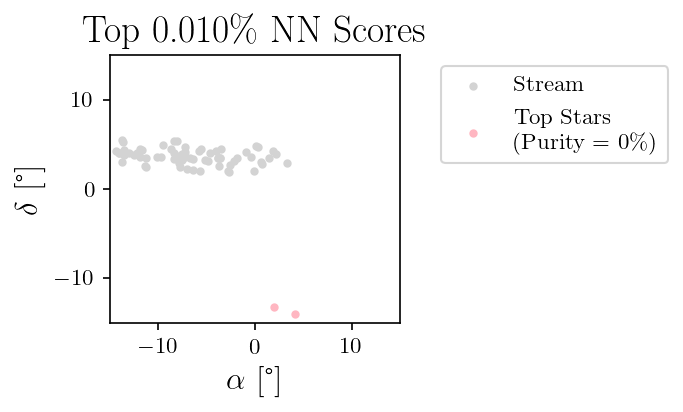

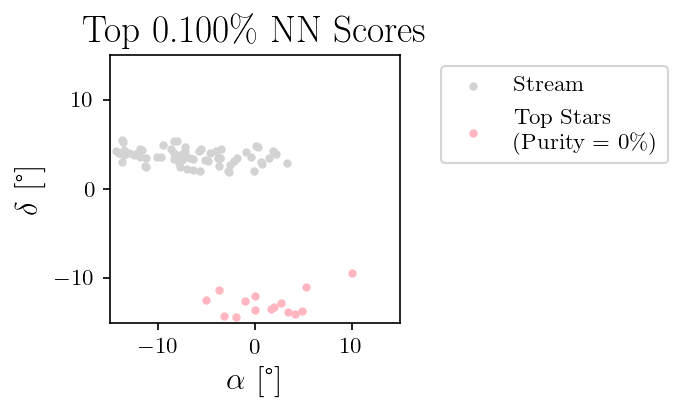

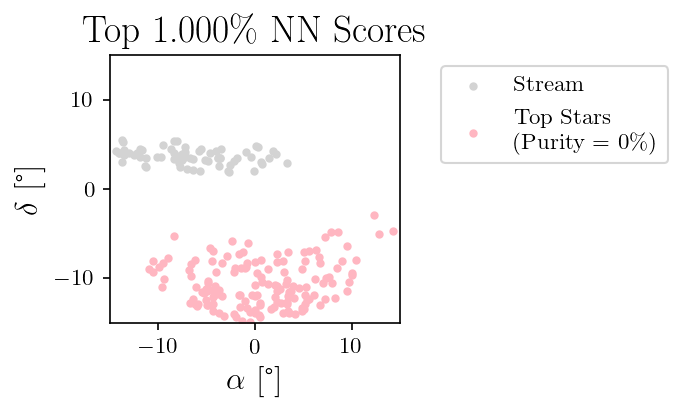

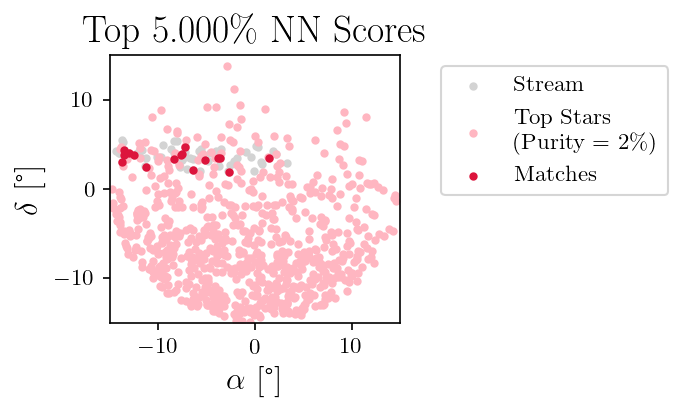

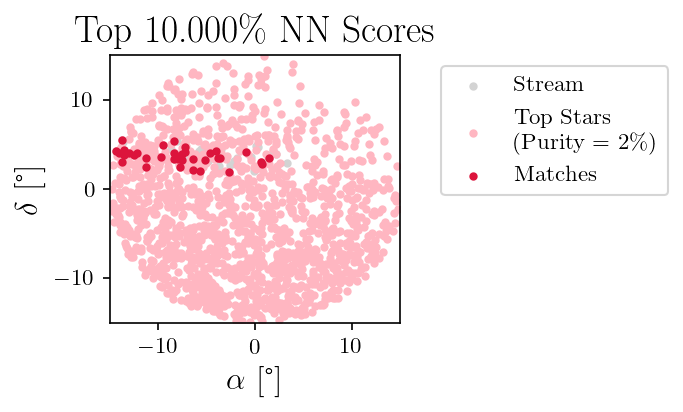

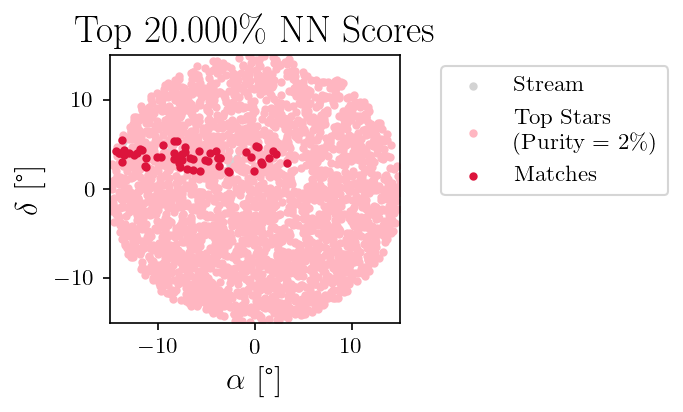

In [57]:
### Load best weights
model.load_weights("weights.h5")

### Add the NN prediction score to the test set: 
test["nn_score"] = model.predict(x_test)
fake_eff_baseline, real_eff_baseline, thresholds = roc_curve(np.asarray(y_test), test.nn_score)
auc_baseline = auc(fake_eff_baseline, real_eff_baseline)
print("AUC: {:.3f}".format(auc_baseline))

### Plot scores:
plot_results(test)